In [1]:
import torch
import torch.nn as nn

import os
import json
from tqdm import tqdm

import src.models as mdls
import src.utils as utils

# Face recognition imports
from src.models import Triplet
from src.models import ConvEmbedding

from src.utils import TripletLoss
from src.dataloaders import recognition_dataloader

#downloading datasets
config = utils.get_options()


if config['use_colab']:
    utils.colab()
else:
    utils.check_if_datasets_are_downloaded()


import src.dataloaders as dataloaders

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

Moving kaggle file

all datasets are in place


In [2]:
img_size = config['img_size']
# Define a directory to save the checkpoints
checkpoint_dir = "checkpoints/"

# Ensure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#Face detection setup
detection_model = mdls.InspectorGadjet()
dataloader_for_detection = dataloaders.detection_dataloader

# loss_fn = nn.MSELoss()
loss_fn = mdls.combined_loss
optimizer = torch.optim.Adam(detection_model.parameters(), lr=1e-3)
detection_model.to(device)
# loss_fn.to(device)
None

In [4]:
batch = next(iter(dataloader_for_detection))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
batch

[tensor([[[[1.4687e-03, 8.0738e-04, 5.1519e-04,  ..., 1.8531e-03,
            2.2684e-03, 2.2568e-03],
           [1.5840e-03, 6.9204e-04, 4.3829e-04,  ..., 2.1261e-03,
            2.4606e-03, 2.3491e-03],
           [1.5110e-03, 9.8424e-04, 5.0365e-04,  ..., 2.1261e-03,
            2.2068e-03, 2.3760e-03],
           ...,
           [2.1146e-04, 1.6148e-04, 1.1918e-04,  ..., 3.8831e-03,
            3.8754e-03, 3.8101e-03],
           [2.2299e-04, 1.7686e-04, 1.3072e-04,  ..., 3.8793e-03,
            3.8524e-03, 3.7447e-03],
           [2.8835e-04, 2.5759e-04, 2.3837e-04,  ..., 3.8831e-03,
            3.4833e-03, 3.6947e-03]],
 
          [[9.1119e-04, 4.6905e-04, 4.4598e-04,  ..., 1.2303e-03,
            1.0265e-03, 1.0957e-03],
           [9.6886e-04, 4.1138e-04, 3.6140e-04,  ..., 1.1150e-03,
            1.2880e-03, 1.2341e-03],
           [8.2661e-04, 5.5748e-04, 3.8062e-04,  ..., 1.1150e-03,
            1.1265e-03, 1.3303e-03],
           ...,
           [1.8070e-04, 1.1534e-04, 8.

bbox -  tensor([[ 53.2266,  28.0000, 112.5334,  69.7600]], dtype=torch.float64)
bbox -  tensor([[42.1015, 21.1921, 76.2913, 57.2186]], dtype=torch.float64)
bbox -  tensor([[-1., -1., -1., -1.]], dtype=torch.float64)
bbox -  tensor([[-1., -1., -1., -1.]], dtype=torch.float64)


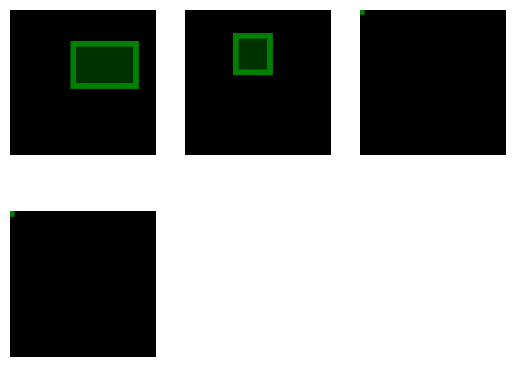

In [6]:
utils.visualize_img(batch, config['batch_size'])

In [ ]:
epochs = config['epochs']
logging = config['logging']
log_interval = config["log_wieghts_interval"]


if logging: 
    # read secrets for cometml logging
    with open('secrets.json') as secrets_file:
        secrets = json.load(secrets_file)

    # init experimenxt
    experiment = Experiment(
        api_key=secrets["api_key"],
        project_name=secrets["project_name"],
        workspace="reu-ds-club", 
    )

    hyper_params = {
        "model_name": config["model"],
        "use_colab": config['use_colab'], 
        "epochs": epochs,
        "batch_size": config['batch_size'], 
        "image_size": config['img_size'], 
    }

    experiment.log_parameters(hyper_params)

for epoch in range(epochs):
    epoch_loss = 0.0
    for sample in (pbar := tqdm(dataloader_for_detection)):

        img, box = sample[0].to(device), sample[1].to(device)
        img = img.to(torch.float32)

        box = box.to(torch.float32)
        optimizer.zero_grad()
        pred = detection_model(img)
        # loss = loss_fn(pred, box)

        loss = loss_fn(pred[0], pred[1], box)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}\tLoss: {epoch_loss / len(dataloader_for_detection)}")

    checkpoint_filename = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': detection_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, checkpoint_filename)

    if logging:
        experiment.log_metric("loss", epoch_loss, step=epoch)
    
    # logging model weights (accorging to log_interval + last epoch)
    if logging and (epoch % log_interval == 0 or epoch == epochs-1):
        torch.save(detection_model, 'model.pth')
        experiment.log_model(name = f"model-epoch-{epoch}", file_or_folder = 'model.pth', file_name = f"model-epoch-{epoch}")
        experiment.log_asset(file_data = 'model.pth', file_name = f"model-epoch-{epoch}")
        print("save model")


if logging:
    experiment.end()

In [ ]:
#Face recognition setup
conv = ConvEmbedding().to(device)
triplet_model = Triplet(conv).to(device)
loss_for_recognition = TripletLoss(margin=5)
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=1e-3)
epochs = 20

In [ ]:
len(recognition_dataloader)

4083

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0

    for i, triplet in enumerate(recognition_dataloader):

        anc, pos, neg = triplet

        preds = triplet_model(anc.to(device), pos.to(device), neg.to(device))

        loss_val = loss_for_recognition(*preds)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        epoch_loss += loss_val.item()
        
        if i%5==0:
            print(f'{epoch} | [{i}/{len(recognition_dataloader)}] LOSS: {loss_val}')
        
    print(f'{epoch} | EPOCH LOSS: {loss_val}')

0 | [0/4083] LOSS: 4.9899678230285645
0 | [5/4083] LOSS: 4.828950881958008
0 | [10/4083] LOSS: 2.0965113639831543
0 | [15/4083] LOSS: 4.954373836517334
0 | [20/4083] LOSS: 4.998796463012695
0 | [25/4083] LOSS: 5.002302646636963
0 | [30/4083] LOSS: 4.9977312088012695
0 | [35/4083] LOSS: 4.992169380187988
0 | [40/4083] LOSS: 4.998960494995117
0 | [45/4083] LOSS: 4.997317790985107
0 | [50/4083] LOSS: 5.000369548797607
0 | [55/4083] LOSS: 5.000226020812988
0 | [60/4083] LOSS: 5.001129150390625
0 | [65/4083] LOSS: 4.996389865875244
0 | [70/4083] LOSS: 5.004185676574707
0 | [75/4083] LOSS: 5.024327278137207
0 | [80/4083] LOSS: 4.999454498291016
0 | [85/4083] LOSS: 4.999821186065674
0 | [90/4083] LOSS: 5.001814842224121
0 | [95/4083] LOSS: 4.934751033782959


KeyboardInterrupt: 